<a href="https://colab.research.google.com/github/wendikardian/exercise_machine_learning/blob/main/LSTM_Weather_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset from : https://www.kaggle.com/datasets/ananthr1/weather-prediction/data <br>

By Wendi Kardian

In [2]:
import pandas as pd

data = pd.read_csv("seattle-weather.csv")
data

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1461 non-null   datetime64[ns]
 1   temp_max  1461 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.0 KB


In [23]:
data['date'] = pd.to_datetime(data['date'])

data = data[['date','temp_max']]
data

,date,temp_max
0,2012-01-01,12.8
1,2012-01-02,10.6
2,2012-01-03,11.7
3,2012-01-04,12.2
4,2012-01-05,8.9
...,...,...
1456,2015-12-27,4.4
1457,2015-12-28,5.0
1458,2015-12-29,7.2
1459,2015-12-30,5.6


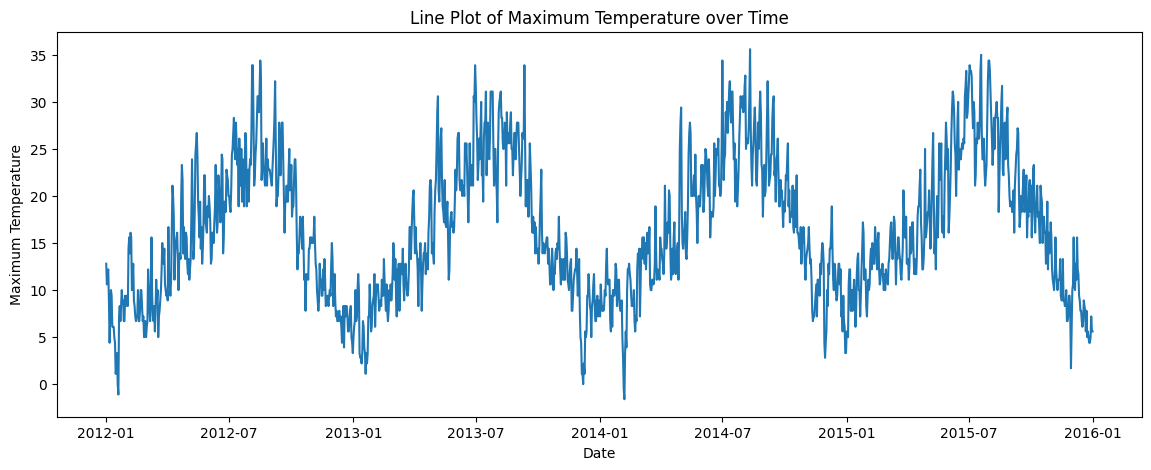

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(14, 5))
sns.lineplot(x='date', y='temp_max', data=data)


plt.xlabel('Date')
plt.ylabel('Maximum Temperature')
plt.title('Line Plot of Maximum Temperature over Time')

plt.show()

In [25]:
date = data['date'].values
temp = data['temp_max'].values

In [26]:
date

array(['2012-01-01T00:00:00.000000000', '2012-01-02T00:00:00.000000000',
       '2012-01-03T00:00:00.000000000', ...,
       '2015-12-29T00:00:00.000000000', '2015-12-30T00:00:00.000000000',
       '2015-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [27]:
temp

array([12.8, 10.6, 11.7, ...,  7.2,  5.6,  5.6])

In [28]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [77]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

date_train, temp_max_train = data['date'], data['temp_max']


min_max_scaler = MinMaxScaler()


temp_max_train_normalized = min_max_scaler.fit_transform(temp_max_train.values.reshape(-1, 1))


temp_max_train_normalized



array([[0.38709677],
       [0.32795699],
       [0.35752688],
       ...,
       [0.23655914],
       [0.19354839],
       [0.19354839]])

In [69]:

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(temp_max_train_normalized, date, test_size = 0.2, random_state = 0 , shuffle=False)



In [70]:
from keras.layers import Dense, LSTM

data_x_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
data_x_test = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

In [71]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
     tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])



In [72]:
max = data['temp_max'].max()
min = data['temp_max'].min()
x = (max - min) * (10/100)
x

3.7200000000000006

In [73]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< x):
      self.model.stop_training = True
      print("\nMAE of the model < 10% of data scale")
callbacks = myCallback()

In [74]:

tf.keras.backend.set_floatx('float64')
history = model.fit(data_x_train ,epochs=500, validation_data=data_x_test, callbacks=[callbacks])

Epoch 1/500
     11/Unknown - 33s 187ms/step - loss: 1.2634 - mae: 1.5891
MAE of the model < 10% of data scale
12/12 [==============================] - 35s 300ms/step - loss: 1.2544 - mae: 1.5790 - val_loss: 0.0218 - val_mae: 0.1756


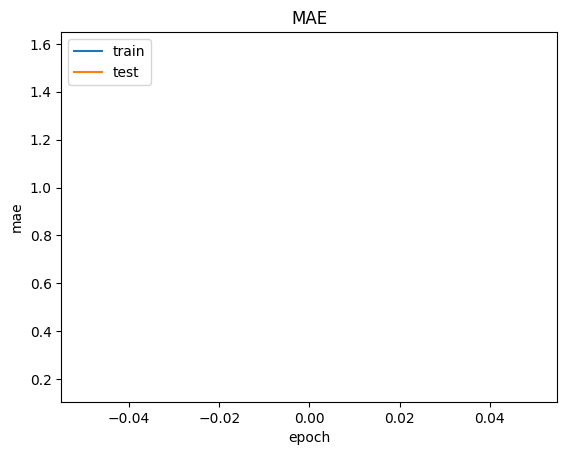

In [75]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


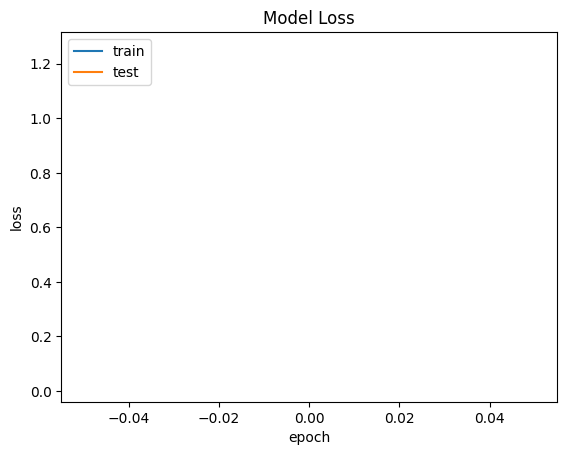

In [78]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()